In [1]:
using Distributions, LinearAlgebra, Plots, Plots.PlotMeasures, Random, LargeMessageCollider
Random.seed!(1234);

In [5]:
p2 = [
Normal(-2.0, 1.2),
Normal(0.0, 1.0),
Normal(3.0, 2.5)]

Categorical(normalize_logprob_array(logpdf.(p2, 1.)))

Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.0392180155813443, 0.6496656066276035, 0.31111637779105217])

In [2]:
# Generate a synthetic data
A = [0.8 0.1 0.1; 0.1 0.7 0.3; 0.1 0.2 0.6]
emmision = [Normal(-3.5, 1.), Normal(-1., 0.5), Normal(3., 1.5)]

T = 100

z_real = []
y_real = []

push!(z_real, rand(Categorical(ones(3)./3)))
push!(y_real, rand(emmision[z_real[1]]))
for t=2:T
    push!(z_real, rand(Categorical(A[:,z_real[t-1]])))
    push!(y_real, rand(emmision[z_real[t]]))
end

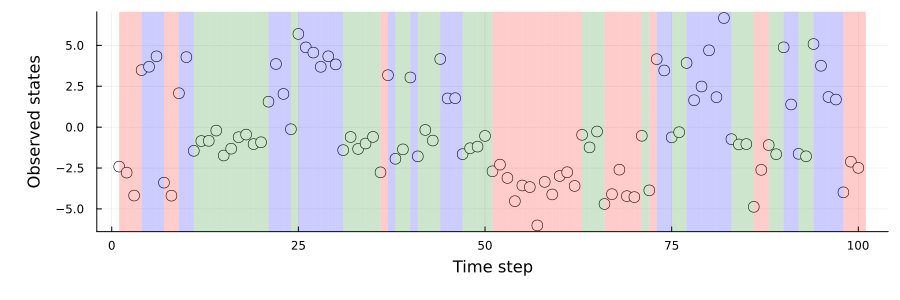

In [3]:
s1 = scatter(y_real, color=:white, markersize=6, legend=false)
colors_list = [:red, :green, :blue]

for t=1:T
    vspan!(s1,[t,t+1], color=colors_list[z_real[t]], alpha=0.2)
end

xaxis!("Time step")
yaxis!("Observed states")

plot(s1, size=(900,300), bottom_margin = 10mm, left_margin=10mm)

In [4]:
# Utility function sending message upward as categorical dist
function message_up(y)
    logp = logpdf.(emmision, y) # calculate logpdfs
    p = normalize_logprob_array(logp) # probability of categories. log-sum-exp followed by normalization
    Categorical(p) # Categorical message
end
;

In [5]:
# Forward Pass
p1 = Categorical(ones(3)./3) # prior distribution

forward_estimates = Array{Categorical}(undef, T)
measure = message_up(y_real[1]) # measurement belief 
forward_estimates[1] = p1 * measure # update step

for t=2:T
    predict = A*forward_estimates[t-1] # prediction belief
    measure = message_up(y_real[t]) # measurement belief
    forward_estimates[t] = predict * measure # update step
end

In [6]:
# Backward Pass
pT = Categorical(ones(3)./3) # This is like setting β_T to 1

backward_estimates = Array{Categorical}(undef, T)
backward_estimates[T] = pT

for t=T-1:-1:1
    measure = message_up(y_real[t+1]) # measurement belief 
    postdict = measure*backward_estimates[t+1] # postdict belief
    backward_estimates[t] = A\postdict # update step
end

In [7]:
# Forward - Backward Smoothing
forward_backward = forward_estimates.*backward_estimates;

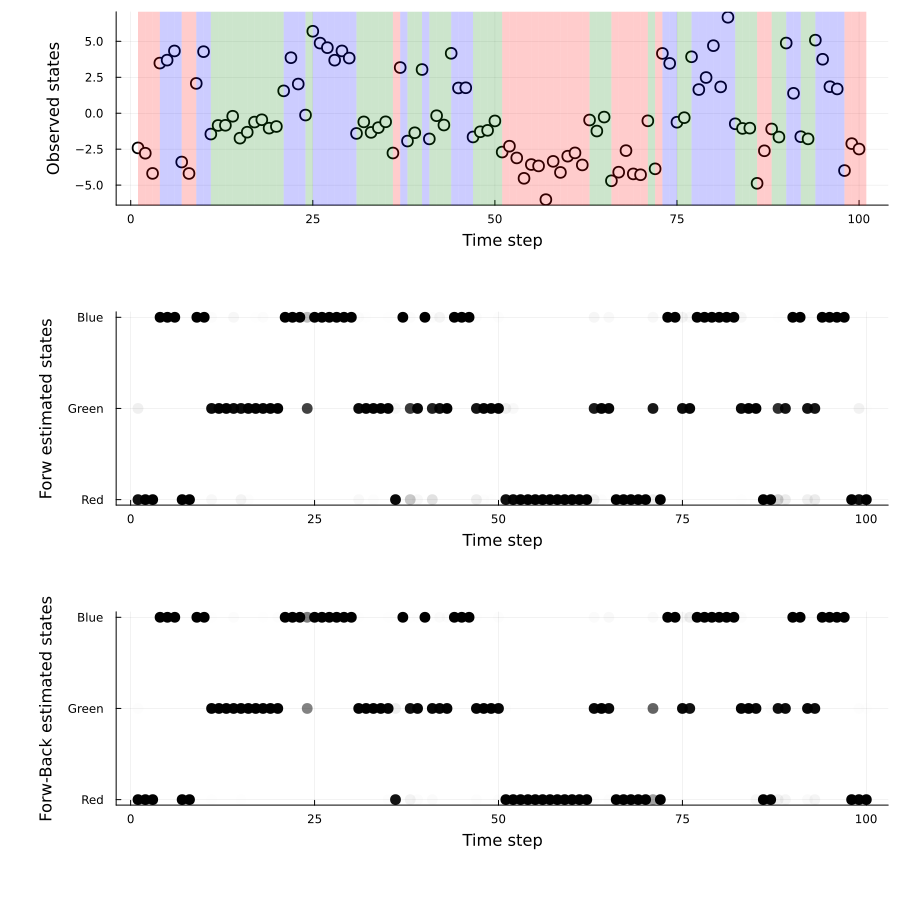

In [8]:
s1 = scatter(y_real, color=:white, markersize=6, legend=false, bottom_margin = 10mm, left_margin=10mm)
colors_list = [:red, :green, :blue]

for t=1:T
    vspan!(s1,[t,t+1], color=colors_list[z_real[t]], alpha=0.2)
end

xaxis!("Time step")
yaxis!("Observed states")

s2 = scatter((1,1),markeralpha=forward_estimates[1].p[1], legend=false, color=:black, markersize=6)
scatter!((1,2),markeralpha=forward_estimates[1].p[2], color=:black, markersize=6)
scatter!((1,3),markeralpha=forward_estimates[1].p[3], color=:black, markersize=6)
for t=2:T-1
    scatter!((t,1),markeralpha=forward_estimates[t].p[1], color=:black, markersize=6)
    scatter!((t,2),markeralpha=forward_estimates[t].p[2], color=:black, markersize=6)
    scatter!((t,3),markeralpha=forward_estimates[t].p[3], color=:black, markersize=6)
end
scatter!((T,1),markeralpha=forward_estimates[T].p[1], color=:black, markersize=6)
scatter!((T,2),markeralpha=forward_estimates[T].p[2], color=:black, markersize=6)
scatter!((T,3),markeralpha=forward_estimates[T].p[3], color=:black, markersize=6, bottom_margin = 10mm, left_margin=10mm)

xaxis!("Time step")
yaxis!("Forw estimated states")
yticks!([1,2,3],["Red", "Green", "Blue"])

s3 = scatter((1,1),markeralpha=forward_backward[1].p[1], legend=false, color=:black, markersize=6)
scatter!((1,2),markeralpha=forward_backward[1].p[2], color=:black, markersize=6)
scatter!((1,3),markeralpha=forward_backward[1].p[3], color=:black, markersize=6)
for t=2:T-1
    scatter!((t,1),markeralpha=forward_backward[t].p[1], color=:black, markersize=6)
    scatter!((t,2),markeralpha=forward_backward[t].p[2], color=:black, markersize=6)
    scatter!((t,3),markeralpha=forward_backward[t].p[3], color=:black, markersize=6)
end
scatter!((T,1),markeralpha=forward_backward[T].p[1], color=:black, markersize=6)
scatter!((T,2),markeralpha=forward_backward[T].p[2], color=:black, markersize=6)
scatter!((T,3),markeralpha=forward_backward[T].p[3], color=:black, markersize=6, bottom_margin = 10mm, left_margin=10mm)

xaxis!("Time step")
yaxis!("Forw-Back estimated states")
yticks!([1,2,3],["Red", "Green", "Blue"])

plot(s1, s2, s3, layout = (3, 1), size=(900,900))

In [9]:
# Correction Smoothing (Just to check if same with forward-backward)

smooth_estimates = Array{Categorical}(undef, T)
smooth_estimates[T] = forward_estimates[T]

joint_dists = Array{Matrix}(undef, T-1)

for t=T-1:-1:1
    smooth_estimates[t], joint_dists[t] = transit(forward_estimates[t],smooth_estimates[t+1],A)
end

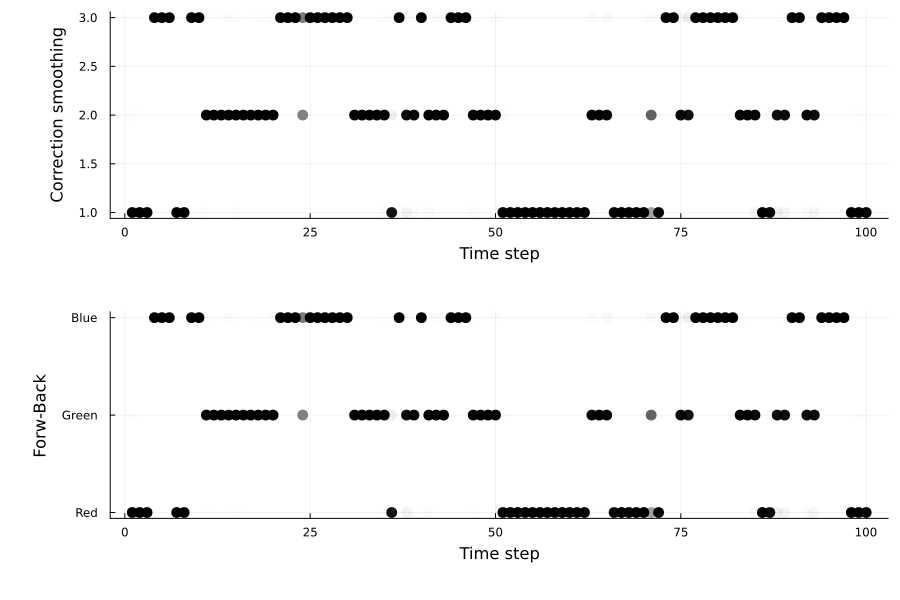

In [10]:
s1 = scatter((1,1),markeralpha=smooth_estimates[1].p[1], legend=false, color=:black, markersize=6)
scatter!((1,2),markeralpha=smooth_estimates[1].p[2], color=:black, markersize=6)
scatter!((1,3),markeralpha=smooth_estimates[1].p[3], color=:black, markersize=6)
for t=2:T-1
    scatter!((t,1),markeralpha=smooth_estimates[t].p[1], color=:black, markersize=6)
    scatter!((t,2),markeralpha=smooth_estimates[t].p[2], color=:black, markersize=6)
    scatter!((t,3),markeralpha=smooth_estimates[t].p[3], color=:black, markersize=6)
end
scatter!((T,1),markeralpha=smooth_estimates[T].p[1], color=:black, markersize=6)
scatter!((T,2),markeralpha=smooth_estimates[T].p[2], color=:black, markersize=6)
scatter!((T,3),markeralpha=smooth_estimates[T].p[3], color=:black, markersize=6, bottom_margin = 10mm, left_margin=10mm)

xaxis!("Time step")
yaxis!("Correction smoothing")

s2 = scatter((1,1),markeralpha=forward_backward[1].p[1], legend=false, color=:black, markersize=6)
scatter!((1,2),markeralpha=forward_backward[1].p[2], color=:black, markersize=6)
scatter!((1,3),markeralpha=forward_backward[1].p[3], color=:black, markersize=6)
for t=2:T-1
    scatter!((t,1),markeralpha=forward_backward[t].p[1], color=:black, markersize=6)
    scatter!((t,2),markeralpha=forward_backward[t].p[2], color=:black, markersize=6)
    scatter!((t,3),markeralpha=forward_backward[t].p[3], color=:black, markersize=6)
end
scatter!((T,1),markeralpha=forward_backward[T].p[1], color=:black, markersize=6)
scatter!((T,2),markeralpha=forward_backward[T].p[2], color=:black, markersize=6)
scatter!((T,3),markeralpha=forward_backward[T].p[3], color=:black, markersize=6, bottom_margin = 10mm, left_margin=10mm)

xaxis!("Time step")
yaxis!("Forw-Back")
yticks!([1,2,3],["Red", "Green", "Blue"])

plot(s1, s2, layout = (2, 1), size=(900,600))